# [How to Generate Images with Variational Autoencoders(VAE) (Create VAE from scratch using Keras and TensorFlow)](https://www.machinelearningnuggets.com/how-to-generate-images-with-variational-autoencoders-vae-and-keras/)

In [ ]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf

In [ ]:
import os

In [ ]:
# locally
base_dir = "./kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/train/"

In [ ]:
#GoogleColab
'''
# Initialize an empty repository in a temporary directory
!git init inf4039_repo
%cd inf4039_repo

# Add the GitHub repository as the remote origin
!git remote add origin https://github.com/vytkuc/inf4039_2024_autumn.git

# Enable sparse checkout to download only the specific folder
!git config core.sparseCheckout true

# Define the path you want to clone
folder_to_clone = "lab08_autoencoders/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/train"
with open(".git/info/sparse-checkout", "w") as file:
    file.write(folder_to_clone)

# Pull only the specified folder from the main branch
!git pull origin main

base_dir = "/content/inf4039_repo/" + folder_to_clone

import os
os.listdir(base_dir)
'''

In [ ]:
batch_size = 32
img_size = 128

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  label_mode="int",
  validation_split=0.02,
  subset="training",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)


Found 3115 files belonging to 36 classes.
Using 3053 files for training.


In [ ]:
validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Using 623 files for validation.


In [ ]:
import numpy as np
x_train = np.array([])
for x, y in training_set:
  x_train = np.concatenate([x])

In [ ]:
x_test = np.array([])
for x, y in validation_set:
  x_test = np.concatenate([x])

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


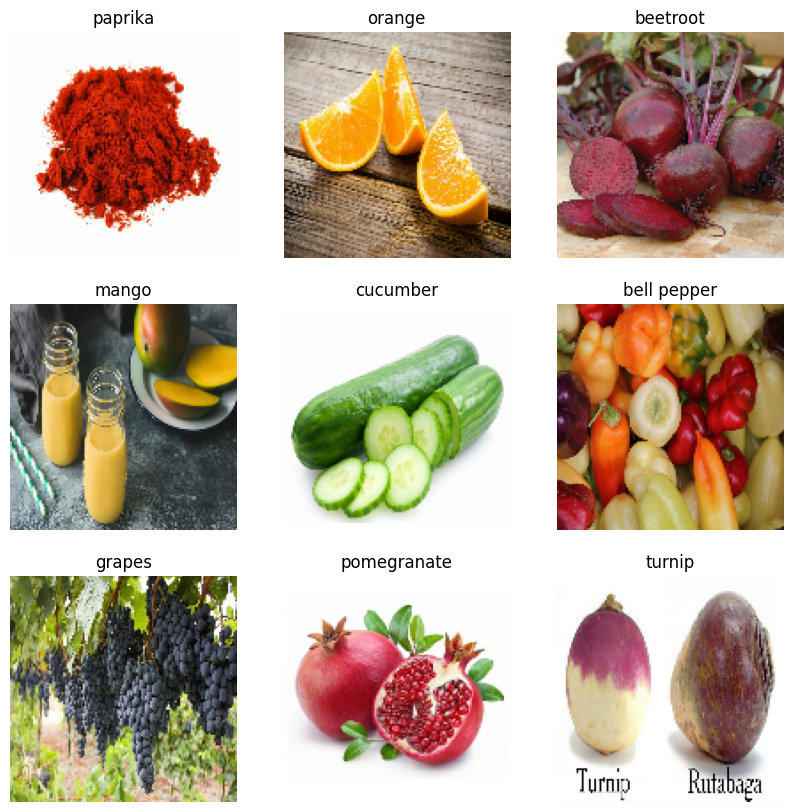

In [ ]:
import matplotlib.pyplot as plt
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=500, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 6277425.0000 - kl_loss: 0.0022 - reconstruction_loss: 6277.4253 - val_loss: 5525516.5000 - val_kl_loss: 813.4263 - val_reconstruction_loss: 5524.7026
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 6275673.0000 - kl_loss: 955.0159 - reconstruction_loss: 6274.7178 - val_loss: 5498070.0000 - val_kl_loss: 140.5247 - val_reconstruction_loss: 5497.9297
Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 6239221.5000 - kl_loss: 164.3745 - reconstruction_loss: 6239.0576 - val_loss: 5400178.5000 - val_kl_loss: 642.6884 - val_reconstruction_loss: 5399.5361
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 6113232.0000 - kl_loss: 747.9578 - reconstruction_loss: 6112.4844 - val_loss: 5072159.5000 - val_kl_loss: 3962.6680 - val_reconstruction_loss: 5068.1968
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 5663811.0000 - kl_loss: 4609.7969 - reconst

1/1 [==============================] - 1s 600ms/step


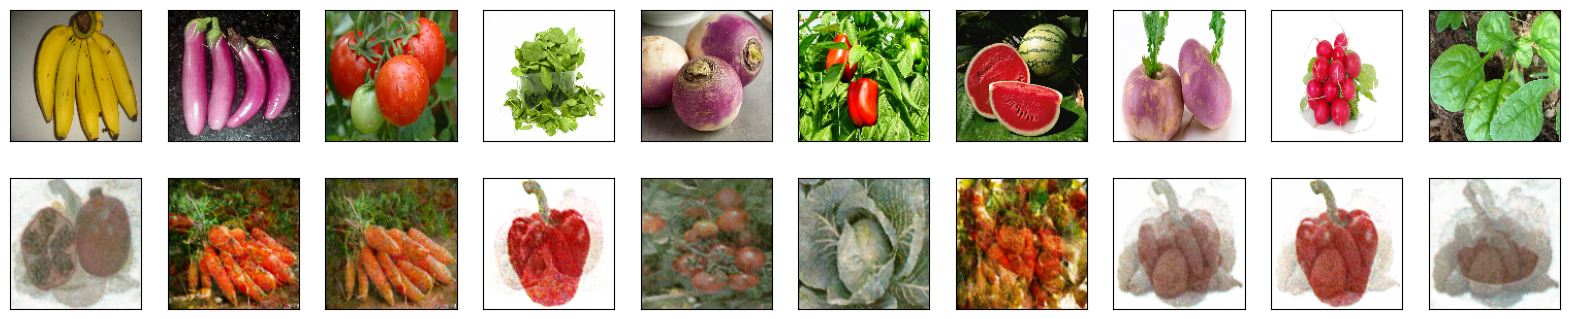

In [ ]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 247ms/step


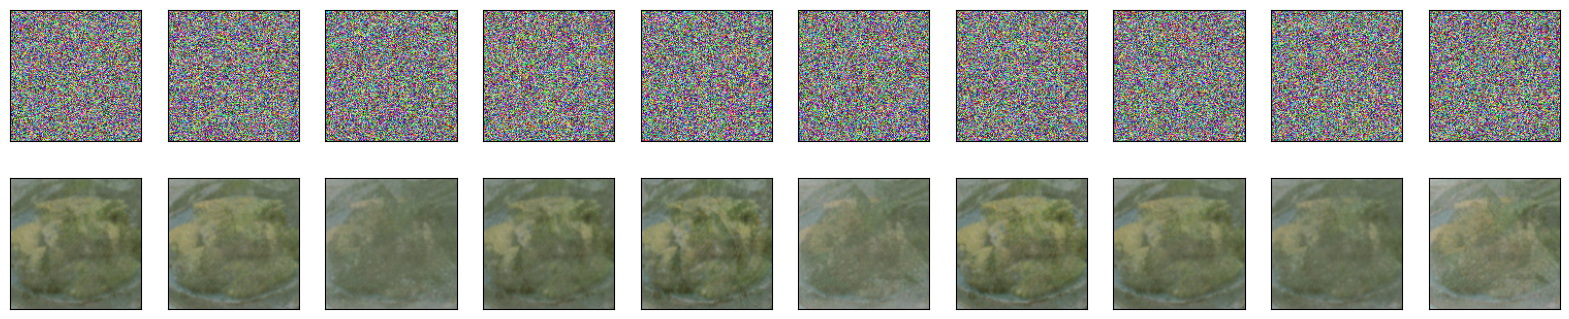

In [ ]:
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   4640        ['conv2d[0][0]']                 
                                                                                            

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 1048576)           3145728   
                                                                 
 reshape (Reshape)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      131200    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     32832     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 32)     8224

In [ ]:
tf.keras.utils.plot_model(vae,"model.png", show_shapes = True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
